In [82]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

In [22]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.simple_sbml import SimpleSBML
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix

from SBMLLint.games.som import SOM
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

In [3]:
os.getcwd()

'/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/notebook'

In [4]:
# Load relevant bigg models
# bigg constants
BIGG_RESULTS = "results"
BIGG_ID = "bigg_id"
BIGG_GENECOUNT = "gene_count"
BIGG_REACTION_COUNT = "reaction_count"
BIGG_ORGANISM = "organism"
BIGG_METABOLITE_COUNT = "metabolite_count"
import requests
res = requests.get('http://bigg.ucsd.edu/api/v2/models')
bigg_models = res.json()[BIGG_RESULTS]
bigg_ids = [bigg[BIGG_ID] for bigg in bigg_models]
bigg_models[:1]

[{'bigg_id': 'e_coli_core',
  'gene_count': 137,
  'reaction_count': 95,
  'organism': 'Escherichia coli str. K-12 substr. MG1655',
  'metabolite_count': 72}]

In [5]:
print("number of BiGG models: %d" % len(bigg_models))
# Check the range of the model size
smallest_bigg = ""
biggest_bigg = ""
current_sm_reactioncount = 100000
current_bg_reactioncount = 0
for big in bigg_models:
  if big[BIGG_REACTION_COUNT] < current_sm_reactioncount:
    smallest_bigg = big[BIGG_ID]
    current_sm_reactioncount = big[BIGG_REACTION_COUNT]
  if big[BIGG_REACTION_COUNT] > current_bg_reactioncount:
    biggest_bigg = big[BIGG_ID]
    current_bg_reactioncount = big[BIGG_REACTION_COUNT]
print("Smallest model is: %s (has %d reactions)" % (smallest_bigg, current_sm_reactioncount))
print("Biggest model is: %s (has %d reactions)" % (biggest_bigg, current_bg_reactioncount))

number of BiGG models: 108
Smallest model is: e_coli_core (has 95 reactions)
Biggest model is: Recon3D (has 10600 reactions)


In [81]:
bigg_df = pd.DataFrame(bigg_models).set_index(BIGG_ID)
bigg_df.sort_values(by=BIGG_REACTION_COUNT, 
                    inplace=True)
bigg_df.head()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
e_coli_core,137,95,Escherichia coli str. K-12 substr. MG1655,72
iAB_RBC_283,346,469,Homo sapiens,342
iIS312,312,519,Trypanosoma cruzi Dm28c,606
iIS312_Amastigote,312,519,Trypanosoma cruzi Dm28c,606
iIS312_Epimastigote,312,519,Trypanosoma cruzi Dm28c,606


In [75]:
bigg_df.loc['e_coli_core']

gene_count                                                137
reaction_count                                             95
organism            Escherichia coli str. K-12 substr. MG1655
metabolite_count                                           72
Name: e_coli_core, dtype: object

(array([ 1.,  1.,  7.,  5., 11.,  5.,  1.,  1.,  1.,  1.,  3.,  5., 58.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   95. ,   305.1,   515.2,   725.3,   935.4,  1145.5,  1355.6,
         1565.7,  1775.8,  1985.9,  2196. ,  2406.1,  2616.2,  2826.3,
         3036.4,  3246.5,  3456.6,  3666.7,  3876.8,  4086.9,  4297. ,
         4507.1,  4717.2,  4927.3,  5137.4,  5347.5,  5557.6,  5767.7,
         5977.8,  6187.9,  6398. ,  6608.1,  6818.2,  7028.3,  7238.4,
         7448.5,  7658.6,  7868.7,  8078.8,  8288.9,  8499. ,  8709.1,
         8919.2,  9129.3,  9339.4,  9549.5,  9759.6,  9969.7, 10179.8,
        10389.9, 10600. ]),
 <a list of 50 Patch objects>)

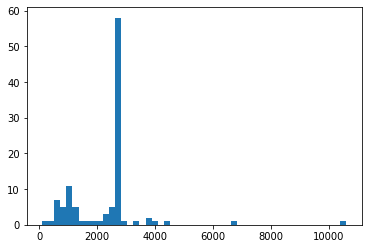

In [86]:
plt.hist(bigg_df[BIGG_REACTION_COUNT], bins=50)

In [6]:
# Download it to BiGG folder - executed so commentized for now
# from urllib.request import urlopen
# for bigg_id in bigg_ids:
#   url_str = "http://bigg.ucsd.edu/static/models/" + bigg_id + ".xml"
#   url_connect = urlopen(url_str)
#   contents = url_connect.read()
#   file = open(os.path.join(cn.BIGG_DIR, bigg_id + ".xml"), 'wb')
#   file.write(contents)
#   file.close()

In [49]:
bigg_file = os.path.join(cn.BIGG_DIR, smallest_bigg+".xml")
bigg_file

'/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/data/bigg/e_coli_core.xml'

In [12]:
simple = SimpleSBML()
simple.initialize(bigg_file)
# simple.reactionsjson t

In [48]:
# count = 0
# for reaction in simple.reactions:
#   if reaction.category != cn.REACTION_BOUNDARY:
#     print(reaction.makeIdentifier(is_include_kinetics=False))
#   count += 1
#   if count > 10:
#     break

In [59]:
# LP method for bigg
# if want to suppress warnings
# import warnings
# warnings.filterwarnings('ignore')


import time
lp_begin = time.time()
data_dir=cn.BIGG_DIR
bigg_files = [f for f in os.listdir(data_dir) if f[-4:] == ".xml"]
simple = SimpleSBML()
count = 0
for f in bigg_files[:1]:
  count += 1
  fpath = os.path.join(cn.BIGG_DIR, f)
  simple.initialize(fpath)
  s = StoichiometryMatrix(simple)
  num_total_reactions = len(simple.reactions)
  num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
  print("number of total reactions: %d" % num_total_reactions)
  print("number of total nonbdry: %d" % num_nonbdry_reactions)
  consistent = s.isConsistent()
  if not consistent:
    print("%s is not consistent! Error detected\n" % f)
  else:
    print("%s is consistent" % f)
lp_end=time.time()
print("Total LP time for %d models is %f" % (count, lp_end - lp_begin))

number of total reactions: 6663
number of total nonbdry: 6021


/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/SBMLLint/common/stoichiometry_matrix.py:88: OptimizeWarning:

Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.

/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/SBMLLint/common/stoichiometry_matrix.py:88: OptimizeWarning:

Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.

//anaconda3/envs/sbmllint_env/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning:

Ill-conditioned matrix (rcond=6.96082e-20): result may not be accurate.

//anaconda3/envs/sbmllint_env/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning:

Ill-conditioned matrix (rco

KeyboardInterrupt: 

In [60]:
f

'iCHOv1.xml'

In [61]:
bigg_files[:5]

['iCHOv1.xml',
 'iYL1228.xml',
 'iIS312.xml',
 'iSDY_1059.xml',
 'iEC1356_Bl21DE3.xml']

In [63]:
time.time() - lp_begin

3822.363301753998

In [17]:
m = GAMES_PP(simple)

In [18]:
res = m.analyze()

Model analyzed...
At least one error found.



In [44]:
# understanding errors
ERROR_TYPE = "error_type"
TYPE_I = "type1"
TYPE_II = "type2"
TYPE_III = "type3"
CANCELING = "canceling"
ECHELON = "echelon"
ERRORS = [TYPE_I, TYPE_II, TYPE_III, CANCELING, ECHELON]
errortype_dic = {TYPE_I: gr.reportTypeOneError,
                 TYPE_II: gr.reportTypeTwoError,
                 TYPE_III: gr.reportTypeThreeError,
                 CANCELING: gr.reportCancelingError,
                 ECHELON: gr.reportEchelonError
                }
summary = m.error_summary
summary[0]

ErrorSummnary(type='echelon', errors=[R_ACONTa: {M_cit_c} -> , R_FUM: {M_fum_c} -> , R_ICL:  -> {M_succ_c}, R_SUCCt2_2: {M_glx_c} -> , R_AKGt2r: {M_akg_e} -> , R_CS:  -> {M_acon_C_c}, R_AKGDH: 2.16 {M_akg_c} -> , R_PGL:  -> {M_6pgc_c}, R_ATPS4r: 4.00 {M_h_e} -> , R_ACONTb:  -> {M_icit_c}, R_PFK:  -> {M_fdp_c}, R_SUCDi:  -> {M_mal__L_c}, R_PYRt2: {M_pyr_e} -> , R_LDH_D:  -> 1.14 {M_pyr_c}, R_D_LACt2: {M_lac__D_e} -> , R_TALA: {M_s7p_c} -> , R_ME1:  -> {M_lac__D_c}, R_PDH: 6.30 {M_h_c} -> , R_ACKr: {M_ac_c} -> , R_FRUpts2: {M_fru_e} -> , R_FUMt2_2: {M_fum_e} -> , R_TKT1:  -> {M_e4p_c}, R_GLCpts: {M_glc__D_e} -> , R_ADK1: {M_pi_c} -> , R_GLNabc: {M_gln__L_e} -> , R_ACt2r:  -> {M_actp_c}, R_GLUt2r: {M_glu__L_e} -> , R_PTAr:  -> {M_ac_e}, R_GLNS:  -> 1.00 {M_gln__L_c}, R_ETOHt2r: {M_etoh_e} -> , R_GAPD:  -> {M_13dpg_c}, R_ICDHyr:  -> 0.65 {M_glu__L_c}, R_ALCD2x: {M_etoh_c} -> , R_PIt2r:  -> 1.00 {M_pep_c}, R_G6PDH2r:  -> {M_6pgl_c}, R_ENO:  -> 1.00 {M_pi_e}, R_MALt2_2: {M_mal__L_e} -> , R_P

In [37]:
rep = gr.reportEchelonError(m.echelon_errors)

In [43]:
print(rep[0])


We detected a mass imbalance
: 0.59 M_ru5p__D_c + 0.41 M_2pg_c + 0.53 M_coa_c + 0.70 M_lac__D_c + 0.03 M_pi_e + 0.09 M_e4p_c + 1.91 M_h_e + 0.19 M_mal__L_c + M_cit_c + 3.18 M_glu__L_c + 1.50 M_accoa_c + 0.12 M_co2_c + 0.05 M_gln__L_c + 3.00 M_pi_c + 0.50 M_nad_c + 0.50 M_icit_c + 2.25 M_adp_c + 0.25 M_nadph_c + 0.00 M_q8h2_c -> 0.81 M_g6p_c + 0.81 M_dhap_c + 0.94 M_oaa_c + 0.48 M_pep_c + 0.50 M_pyr_c + 2.26 M_nh4_c + 0.25 M_nadp_c + 0.41 M_o2_c + 0.50 M_nadh_c + M_succ_c + 2.00 M_succoa_c + 0.00 M_q8_c + 0.02 M_for_c + 14.00 M_h_c + 1.28 M_acald_c + 2.00 M_h2o_c + 2.38 M_atp_c + 0.50 M_glx_c + M_akg_c

from the following isolation set.

1. R_BIOMASS_Ecoli_core_w_GAM: 1.50 M_3pg_c + 3.75 M_accoa_c + 59.81 M_atp_c + 0.36 M_e4p_c + 0.07 M_f6p_c + 0.13 M_g3p_c + 0.20 M_g6p_c + 0.26 M_gln__L_c + 4.94 M_glu__L_c + 59.81 M_h2o_c + 3.55 M_nad_c + 13.03 M_nadph_c + 1.79 M_oaa_c + 0.52 M_pep_c + 2.83 M_pyr_c + 0.90 M_r5p_c -> 59.81 M_adp_c + 4.12 M_akg_c + 3.75 M_coa_c + 59.81 M_h_c + 3.55 M_na